In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_BN_2(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=32, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
max_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_16 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_39 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_40 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1971 - acc: 0.3975
Epoch 00001: val_loss improved from inf to 2.07523, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_3_conv_checkpoint/001-2.0752.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.1970 - acc: 0.3976 - val_loss: 2.0752 - val_acc: 0.3778
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2396 - acc: 0.6314
Epoch 00002: val_loss improved from 2.07523 to 1.74806, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_3_conv_checkpoint/002-1.7481.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.2396 - acc: 0.6314 - val_loss: 1.7481 - val_acc: 0.5125
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7721 - acc: 0.7646
Epoch 00003: val_loss did not improve from 1.74806
36805/36805 [===

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9941
Epoch 00029: val_loss did not improve from 1.74806
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0347 - acc: 0.9941 - val_loss: 3.2815 - val_acc: 0.5094
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9939
Epoch 00030: val_loss did not improve from 1.74806
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0337 - acc: 0.9939 - val_loss: 3.1020 - val_acc: 0.5288
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9931
Epoch 00031: val_loss did not improve from 1.74806
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0359 - acc: 0.9931 - val_loss: 2.9974 - val_acc: 0.5395
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9944
Epoch 00032: val_loss did not improve from 1.74806
36805/36805 [===========

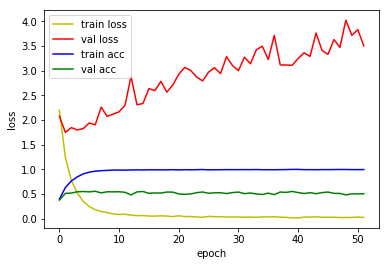

4815/4815 [==============================] - 2s 484us/sample - loss: 1.7541 - acc: 0.5119
Loss: 1.75411346037935 Accuracy: 0.51194185

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9557 - acc: 0.4132
Epoch 00001: val_loss improved from inf to 1.61347, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_4_conv_checkpoint/001-1.6135.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.9556 - acc: 0.4132 - val_loss: 1.6135 - val_acc: 0.4880
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2749 - acc: 0.6114
Epoch 00002: val_loss improved from 1.61347 to 1.29554, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_4_conv_checkpoint/002-1.2955.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.2749 - acc: 0.6113 - val_loss: 1.2955 - val_acc: 0.6038
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9926
Epoch 00029: val_loss did not improve from 1.17050
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0460 - acc: 0.9925 - val_loss: 1.7336 - val_acc: 0.6341
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9952
Epoch 00030: val_loss did not improve from 1.17050
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0387 - acc: 0.9951 - val_loss: 1.7102 - val_acc: 0.6499
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9946
Epoch 00031: val_loss did not improve from 1.17050
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0396 - acc: 0.9946 - val_loss: 1.7067 - val_acc: 0.6527
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9945
Epoch 00032: val_loss did not improve from 1.17050
36805/36805 [===========

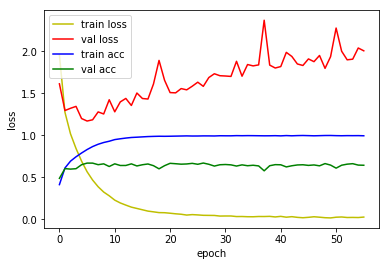

4815/4815 [==============================] - 3s 524us/sample - loss: 1.2705 - acc: 0.6253
Loss: 1.2705463477012895 Accuracy: 0.6253375

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8093 - acc: 0.4493
Epoch 00001: val_loss improved from inf to 1.47936, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_5_conv_checkpoint/001-1.4794.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.8093 - acc: 0.4493 - val_loss: 1.4794 - val_acc: 0.5271
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1890 - acc: 0.6395
Epoch 00002: val_loss improved from 1.47936 to 1.09596, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_5_conv_checkpoint/002-1.0960.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.1891 - acc: 0.6395 - val_loss: 1.0960 - val_acc: 0.6806
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9895
Epoch 00028: val_loss did not improve from 0.89736
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0673 - acc: 0.9895 - val_loss: 1.1643 - val_acc: 0.7335
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9919
Epoch 00029: val_loss did not improve from 0.89736
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0598 - acc: 0.9918 - val_loss: 1.1519 - val_acc: 0.7314
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0620 - acc: 0.9899
Epoch 00030: val_loss did not improve from 0.89736
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0621 - acc: 0.9899 - val_loss: 1.2721 - val_acc: 0.7174
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0653 - acc: 0.9884
Epoch 00031: val_loss did not improve from 0.89736
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9962
Epoch 00058: val_loss did not improve from 0.89736
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0266 - acc: 0.9962 - val_loss: 1.3926 - val_acc: 0.7363
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9980
Epoch 00059: val_loss did not improve from 0.89736
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0199 - acc: 0.9979 - val_loss: 1.3987 - val_acc: 0.7354

1D_CNN_custom_ch_32_BN_2_5_conv Model


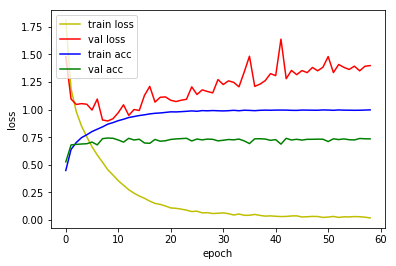

4815/4815 [==============================] - 3s 527us/sample - loss: 0.9768 - acc: 0.7065
Loss: 0.9768210777364911 Accuracy: 0.7065421

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0216 - acc: 0.3740
Epoch 00001: val_loss improved from inf to 1.65726, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_6_conv_checkpoint/001-1.6573.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 2.0216 - acc: 0.3740 - val_loss: 1.6573 - val_acc: 0.4580
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3002 - acc: 0.5997
Epoch 00002: val_loss improved from 1.65726 to 1.14367, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_6_conv_checkpoint/002-1.1437.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.3003 - acc: 0.5996 - val_loss: 1.1437 - val_acc: 0.6455
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2086 - acc: 0.9433
Epoch 00026: val_loss improved from 0.58446 to 0.56117, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_6_conv_checkpoint/026-0.5612.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2086 - acc: 0.9433 - val_loss: 0.5612 - val_acc: 0.8467
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1953 - acc: 0.9480
Epoch 00027: val_loss did not improve from 0.56117
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1954 - acc: 0.9479 - val_loss: 0.5937 - val_acc: 0.8428
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1939 - acc: 0.9476
Epoch 00028: val_loss did not improve from 0.56117
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1939 - acc: 0.9476 - val_loss: 0.6358 - val_acc: 0.8286
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9885
Epoch 00055: val_loss did not improve from 0.56117
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0579 - acc: 0.9885 - val_loss: 0.7277 - val_acc: 0.8288
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0730 - acc: 0.9834
Epoch 00056: val_loss did not improve from 0.56117
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0734 - acc: 0.9833 - val_loss: 0.6813 - val_acc: 0.8369
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9885
Epoch 00057: val_loss did not improve from 0.56117
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0597 - acc: 0.9885 - val_loss: 0.6682 - val_acc: 0.8530
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9898
Epoch 00058: val_loss did not improve from 0.56117
36805/36805 [========================

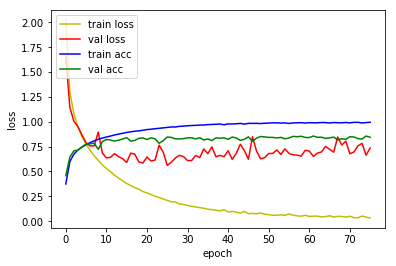

4815/4815 [==============================] - 3s 631us/sample - loss: 0.6278 - acc: 0.8278
Loss: 0.627781481423482 Accuracy: 0.8278297

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1068 - acc: 0.3523
Epoch 00001: val_loss improved from inf to 1.64586, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_7_conv_checkpoint/001-1.6459.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 2.1068 - acc: 0.3523 - val_loss: 1.6459 - val_acc: 0.4771
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3080 - acc: 0.6020
Epoch 00002: val_loss improved from 1.64586 to 1.08133, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_7_conv_checkpoint/002-1.0813.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.3081 - acc: 0.6019 - val_loss: 1.0813 - val_acc: 0.6818
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1845 - acc: 0.9487
Epoch 00024: val_loss did not improve from 0.30249
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1844 - acc: 0.9487 - val_loss: 0.3344 - val_acc: 0.9099
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1695 - acc: 0.9532
Epoch 00025: val_loss improved from 0.30249 to 0.29286, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_7_conv_checkpoint/025-0.2929.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1695 - acc: 0.9532 - val_loss: 0.2929 - val_acc: 0.9161
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1603 - acc: 0.9565
Epoch 00026: val_loss did not improve from 0.29286
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1603 - acc: 0.9566 - val_loss: 0.3560 - val_acc: 0.8987
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9861
Epoch 00053: val_loss did not improve from 0.27885
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0578 - acc: 0.9861 - val_loss: 0.3129 - val_acc: 0.9194
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9910
Epoch 00054: val_loss did not improve from 0.27885
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0436 - acc: 0.9910 - val_loss: 0.3493 - val_acc: 0.9071
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9885
Epoch 00055: val_loss did not improve from 0.27885
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0498 - acc: 0.9884 - val_loss: 0.3260 - val_acc: 0.9187
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.9868
Epoch 00056: val_loss did not improve from 0.27885
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9951
Epoch 00083: val_loss did not improve from 0.27885
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0245 - acc: 0.9950 - val_loss: 0.3230 - val_acc: 0.9220
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9907
Epoch 00084: val_loss did not improve from 0.27885
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0387 - acc: 0.9907 - val_loss: 0.3155 - val_acc: 0.9201
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9917
Epoch 00085: val_loss did not improve from 0.27885
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0326 - acc: 0.9916 - val_loss: 0.3242 - val_acc: 0.9213
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9959
Epoch 00086: val_loss did not improve from 0.27885
36805/36805 [===========

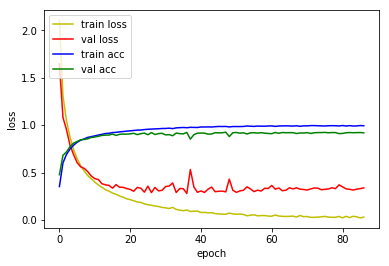

4815/4815 [==============================] - 3s 616us/sample - loss: 0.3390 - acc: 0.9011
Loss: 0.3389925791528985 Accuracy: 0.90114224

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0492 - acc: 0.3668
Epoch 00001: val_loss improved from inf to 1.60867, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_8_conv_checkpoint/001-1.6087.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 2.0492 - acc: 0.3667 - val_loss: 1.6087 - val_acc: 0.5048
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1976 - acc: 0.6369
Epoch 00002: val_loss improved from 1.60867 to 0.93432, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_8_conv_checkpoint/002-0.9343.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.1976 - acc: 0.6368 - val_loss: 0.9343 - val_acc: 0.7298
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0992 - acc: 0.9737
Epoch 00025: val_loss did not improve from 0.21535
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0991 - acc: 0.9737 - val_loss: 0.2236 - val_acc: 0.9355
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0881 - acc: 0.9769
Epoch 00026: val_loss improved from 0.21535 to 0.21060, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_8_conv_checkpoint/026-0.2106.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0881 - acc: 0.9769 - val_loss: 0.2106 - val_acc: 0.9399
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9788
Epoch 00027: val_loss did not improve from 0.21060
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0827 - acc: 0.9788 - val_loss: 0.2245 - val_acc: 0.9357
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9951
Epoch 00053: val_loss did not improve from 0.20031
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0234 - acc: 0.9951 - val_loss: 0.2010 - val_acc: 0.9453
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9961
Epoch 00054: val_loss did not improve from 0.20031
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0203 - acc: 0.9960 - val_loss: 0.2414 - val_acc: 0.9418
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9927
Epoch 00055: val_loss did not improve from 0.20031
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0292 - acc: 0.9926 - val_loss: 0.2171 - val_acc: 0.9359
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9920
Epoch 00056: val_loss did not improve from 0.20031
36805/36805 [========================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9989
Epoch 00083: val_loss did not improve from 0.19983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0084 - acc: 0.9989 - val_loss: 0.2251 - val_acc: 0.9453
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9978
Epoch 00084: val_loss did not improve from 0.19983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0113 - acc: 0.9978 - val_loss: 0.2662 - val_acc: 0.9399
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9930
Epoch 00085: val_loss did not improve from 0.19983
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0251 - acc: 0.9930 - val_loss: 0.2209 - val_acc: 0.9485
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9960
Epoch 00086: val_loss did not improve from 0.19983
36805/36805 [===========

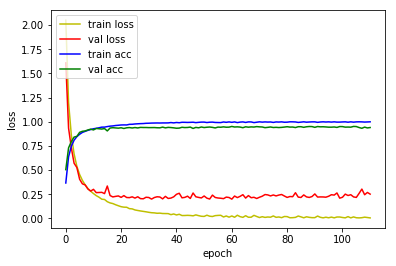

4815/4815 [==============================] - 3s 658us/sample - loss: 0.2767 - acc: 0.9286
Loss: 0.27672895787599056 Accuracy: 0.9285566

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6562 - acc: 0.4858
Epoch 00001: val_loss improved from inf to 1.22262, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_9_conv_checkpoint/001-1.2226.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 1.6562 - acc: 0.4858 - val_loss: 1.2226 - val_acc: 0.6252
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7518 - acc: 0.7715
Epoch 00002: val_loss improved from 1.22262 to 0.53852, saving model to model/checkpoint/1D_CNN_custom_ch_32_BN_2_9_conv_checkpoint/002-0.5385.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.7521 - acc: 0.7715 - val_loss: 0.5385 - val_acc: 0.8418
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9896
Epoch 00025: val_loss did not improve from 0.18279
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0437 - acc: 0.9896 - val_loss: 0.1975 - val_acc: 0.9485
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9923
Epoch 00026: val_loss did not improve from 0.18279
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0355 - acc: 0.9922 - val_loss: 0.2404 - val_acc: 0.9348
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9878
Epoch 00027: val_loss did not improve from 0.18279
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0461 - acc: 0.9878 - val_loss: 0.2152 - val_acc: 0.9420
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9910
Epoch 00028: val_loss did not improve from 0.18279
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9988
Epoch 00055: val_loss did not improve from 0.18279
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0075 - acc: 0.9988 - val_loss: 0.2160 - val_acc: 0.9497
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9969
Epoch 00056: val_loss did not improve from 0.18279
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0134 - acc: 0.9969 - val_loss: 0.2567 - val_acc: 0.9418
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9947
Epoch 00057: val_loss did not improve from 0.18279
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0191 - acc: 0.9946 - val_loss: 0.2148 - val_acc: 0.9502
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9954
Epoch 00058: val_loss did not improve from 0.18279
36805/36805 [===========

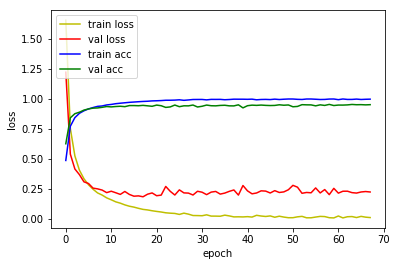

4815/4815 [==============================] - 4s 748us/sample - loss: 0.2363 - acc: 0.9269
Loss: 0.23627439559682012 Accuracy: 0.92689514



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_BN_2'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_BN_2'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_32_BN_2_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_50 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5

4815/4815 [==============================] - 3s 691us/sample - loss: 0.9768 - acc: 0.7065
Loss: 0.9768210777364911 Accuracy: 0.7065421

1D_CNN_custom_ch_32_BN_2_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_64 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_65 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_55 (Activation)   (None

4815/4815 [==============================] - 4s 759us/sample - loss: 0.3390 - acc: 0.9011
Loss: 0.3389925791528985 Accuracy: 0.90114224

1D_CNN_custom_ch_32_BN_2_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_79 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_68 (Activation)   (Non

4815/4815 [==============================] - 4s 768us/sample - loss: 0.2363 - acc: 0.9269
Loss: 0.23627439559682012 Accuracy: 0.92689514
